# Démo calibration Heston

Notebook de contrôle rapide : chargement d'un cache d'options call, calibration Heston (Carr–Madan) avec le script autonome, visualisation de la perte.

- Assure-toi d'avoir installé les dépendances (notamment `torch`).
- Le CSV factice `heston_dummy_calls.csv` provient du cache CBOE et se trouve dans ce dossier.
- Ajuste `max_iters`/`lr` pour une calibration plus fine si besoin.

In [1]:
# Optionnel : installe les dépendances si l'environnement est vierge.
# !pip install -r ../requirements.txt

In [2]:
import torch
from pathlib import Path

print("Torch dispo :", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Torch dispo : 2.9.1+cpu
Device utilisé : cpu


In [3]:
import pandas as pd
from calibrate_heston import calibrate_heston, _params_to_dict, DEVICE, MIN_IV_MATURITY

csv_path = Path("heston_dummy_calls.csv")
if not csv_path.exists():
    raise FileNotFoundError(f"CSV introuvable : {csv_path}")

df_calls = pd.read_csv(csv_path)
display(df_calls.head())
print(f"Lignes: {len(df_calls)} | Maturité min: {df_calls['T'].min():.4f} | Maturité seuil: {MIN_IV_MATURITY}")

,S0,K,T,C_mkt,iv_market
0,278.34,140.0,0.11,139.72,0.7446
1,278.34,160.0,0.11,119.80,0.5611
2,278.34,170.0,0.11,109.90,0.5748
3,278.34,175.0,0.11,104.90,0.5180
4,278.34,190.0,0.11,89.92,0.3970


Lignes: 200 | Maturité min: 0.1100 | Maturité seuil: 0.1


In [4]:
# Calibration rapide (ajuste max_iters/lr au besoin)
params, losses, df_used = calibrate_heston(
    df_calls,
    r=0.02,
    q=0.0,
    max_iters=200,
    lr=0.05,
    device=DEVICE,
    progress=True,
)
params_dict = _params_to_dict(params)
params_dict

d:\PythonDProjects\PaperTradingApp\heston_calibration\calibrate_heston.py:150: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  f"kappa={float(params_dbg.kappa):.4f}, "


[   1/200] loss=317.099821 | kappa=0.6686, theta=0.6686, sigma=0.7186, rho=-0.0250, v0=0.6686
[  20/200] loss=74.941541 | kappa=0.3041, theta=0.3471, sigma=1.3411, rho=-0.4464, v0=0.3301
[  40/200] loss=7.735217 | kappa=0.1298, theta=0.2415, sigma=2.1400, rho=-0.6744, v0=0.1933
[  60/200] loss=2.060364 | kappa=0.0903, theta=0.2195, sigma=2.5648, rho=-0.7314, v0=0.1563
[  80/200] loss=1.855259 | kappa=0.0899, theta=0.2170, sigma=2.6494, rho=-0.7128, v0=0.1480
[ 100/200] loss=1.675346 | kappa=0.1002, theta=0.2186, sigma=2.6292, rho=-0.6668, v0=0.1460
[ 120/200] loss=1.519952 | kappa=0.1145, theta=0.2208, sigma=2.6021, rho=-0.6154, v0=0.1444
[ 140/200] loss=1.402566 | kappa=0.1316, theta=0.2232, sigma=2.5872, rho=-0.5689, v0=0.1420
[ 160/200] loss=1.307574 | kappa=0.1533, theta=0.2258, sigma=2.5785, rho=-0.5300, v0=0.1392
[ 180/200] loss=1.225551 | kappa=0.1838, theta=0.2290, sigma=2.5693, rho=-0.4986, v0=0.1364
[ 200/200] loss=1.146454 | kappa=0.2291, theta=0.2331, sigma=2.5580, rho=-0.4

{'kappa': 0.2291252770480167,
 'theta': 0.23314107528912098,
 'sigma': 2.557960677985298,
 'rho': -0.47497555054105456,
 'v0': 0.13361224832835933}

In [5]:
import numpy as np

final_loss = losses[-1]
rmse = float(np.sqrt(2 * final_loss))
print(f"Points utilisés: {len(df_used)}")
print(f"Perte finale: {final_loss:.6f} | RMSE ~ {rmse:.6f}")
print(
    "Paramètres: "
    f"kappa={params_dict['kappa']:.4f}, "
    f"theta={params_dict['theta']:.4f}, "
    f"sigma={params_dict['sigma']:.4f}, "
    f"rho={params_dict['rho']:.4f}, "
    f"v0={params_dict['v0']:.4f}"
)

Points utilisés: 173
Perte finale: 1.146454 | RMSE ~ 1.514235
Paramètres: kappa=0.2291, theta=0.2331, sigma=2.5580, rho=-0.4750, v0=0.1336


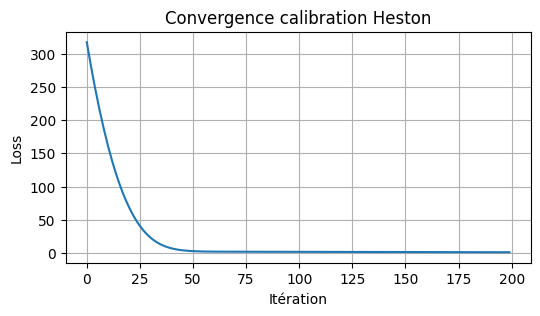

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.xlabel("Itération")
plt.ylabel("Loss")
plt.title("Convergence calibration Heston")
plt.grid(True)
plt.show()